## Potato Disease Detection using CNN

Dataset from https://www.kaggle.com/arjuntejaswi/plant-village

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
df = tf.keras.preprocessing.image_dataset_from_directory(
        '/home/larissa/Potato',shuffle=True, image_size=(256,256),batch_size= 32)

Found 2152 files belonging to 3 classes.


In [21]:
image_size = 256
Batch_size = 32
rgb_chanels = 3
epochs = 50

In [7]:
class_names = df.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

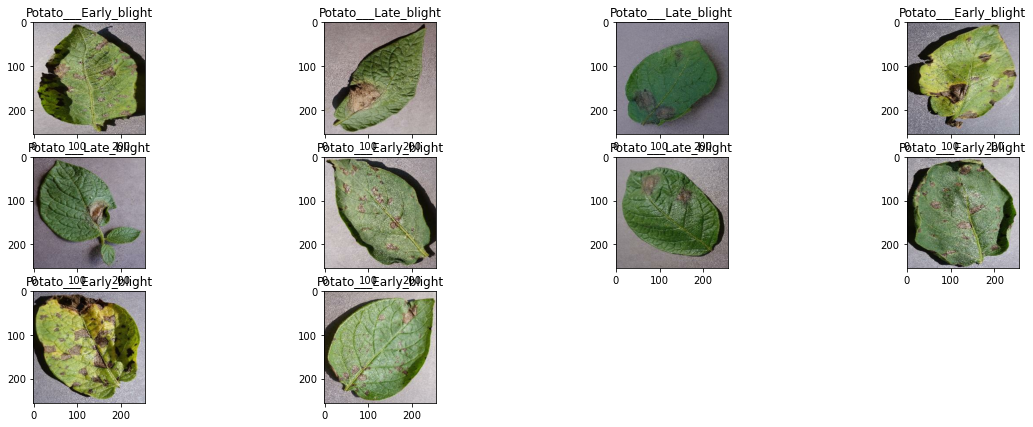

In [8]:
plt.figure(figsize=(20,7))
for image_batch, label_batch in df.take(1):
    for i in range(10):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])

80% training, 10% val, 10% test

In [10]:
def data_part(df,train_split = 0.8, val_split = 0.1, test_split = 0.1,shuffle = True,shuffle_size = 1000):
    df_size = len(df)
    if shuffle:
        df = df.shuffle(shuffle_size,seed = 420)
    train_size = int(train_split*df_size)
    val_size = int(val_split*df_size)
    test_size  = int(test_split*df_size)
    
    train_df = df.take(train_size)
    
    val_df = df.skip(train_size).take(val_size)
    
    test_df = df.skip(train_size).skip(val_size)
    

    return train_df,val_df, test_df

In [11]:
train,val,test = data_part(df)

In [12]:
len(train), len(val), len(test), len(df)

(54, 6, 8, 68)

In [13]:
train = train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test = test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val = val.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
# load and train : GPU and CPU

In [15]:
#Layer for Resizing and Normalization

rescale = tf.keras.Sequential([
    keras.layers.experimental.preprocessing.Resizing(image_size,image_size),
    keras.layers.experimental.preprocessing.Rescaling(1.0/255)
    
])

data_augmentation = tf.keras.Sequential([
  keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [16]:
train = train.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



In [17]:
input_shape_all = (Batch_size,image_size,image_size,rgb_chanels)
n_classes = len(class_names)

In [18]:
model = keras.Sequential([
    rescale,
    keras.layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape_all),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape_all)

In [19]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [22]:
model.compile(optimizer="adam",
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=["accuracy"])

history = model.fit(
train, epochs=epochs, batch_size=Batch_size, verbose=1, validation_data=val)

Epoch 1/50
54/54 [==============================] - 11s 186ms/step - loss: 0.0742 - accuracy: 0.9724 - val_loss: 0.0561 - val_accuracy: 0.9844
Epoch 2/50
54/54 [==============================] - 17s 308ms/step - loss: 0.0505 - accuracy: 0.9789 - val_loss: 0.0390 - val_accuracy: 0.9896
Epoch 3/50
54/54 [==============================] - 11s 207ms/step - loss: 0.0479 - accuracy: 0.9842 - val_loss: 0.0736 - val_accuracy: 0.9792
Epoch 4/50
54/54 [==============================] - 11s 208ms/step - loss: 0.0735 - accuracy: 0.9748 - val_loss: 0.0847 - val_accuracy: 0.9583
Epoch 5/50
54/54 [==============================] - 11s 208ms/step - loss: 0.0418 - accuracy: 0.9865 - val_loss: 0.0627 - val_accuracy: 0.9688
Epoch 6/50
54/54 [==============================] - 16s 291ms/step - loss: 0.0843 - accuracy: 0.9689 - val_loss: 0.0443 - val_accuracy: 0.9844
Epoch 7/50
54/54 [==============================] - 11s 207ms/step - loss: 0.0501 - accuracy: 0.9789 - val_loss: 0.0609 - val_accuracy: 0.9740

In [31]:
scores = model.evaluate(test)
print(f"Test Accuracy: {round(scores[1],4)*100}%")



8/8 [==============================] - 0s 32ms/step - loss: 0.1341 - accuracy: 0.9688
Test Accuracy: 96.88%


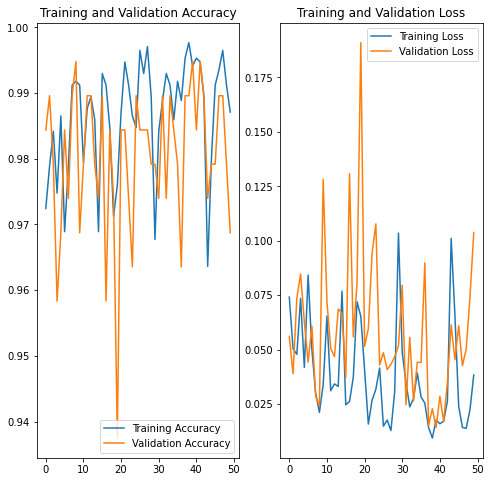

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
predicted label: Potato___Late_blight


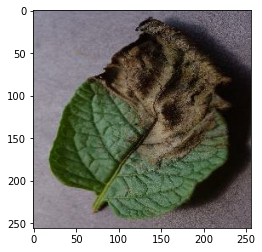

In [46]:
for images_batch, labels_batch in test.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [48]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence



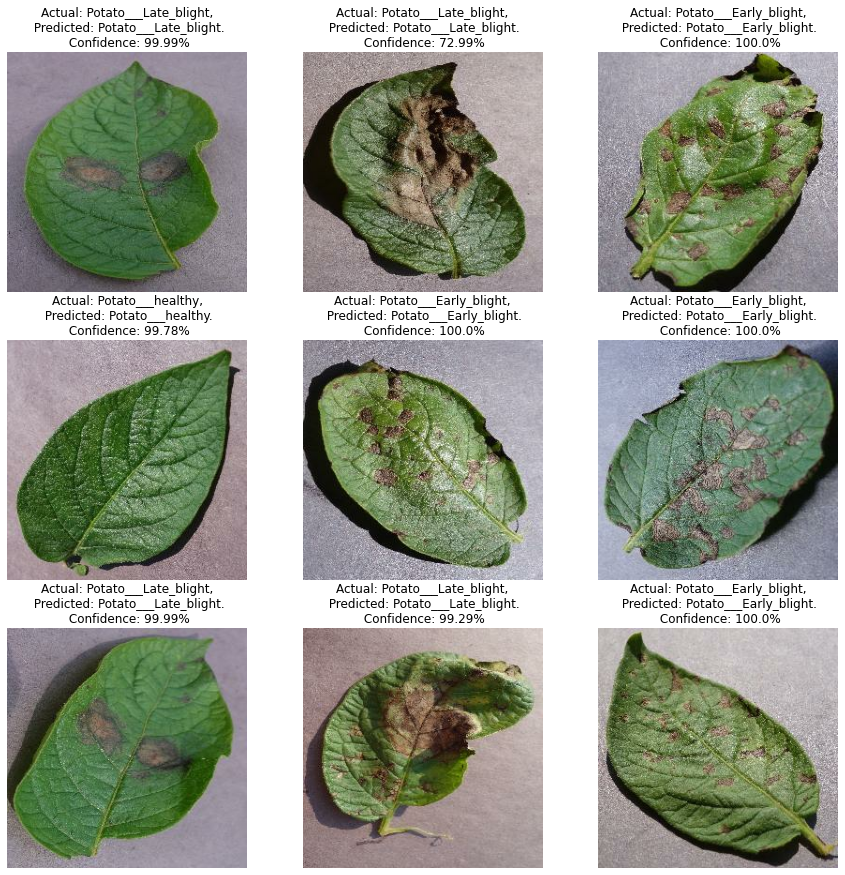

In [49]:

plt.figure(figsize=(15, 15))
for images, labels in test.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        
        actual_class = class_names[labels[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

